In [107]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import matplotlib.pyplot as plt
import json
from glob import glob
from utils import plot_results
from math import ceil
from fisiocomPinn.Net import *
from fisiocomPinn.Trainer import *
from fisiocomPinn.Validator import *
from fisiocomPinn.Loss import *
from fisiocomPinn.Loss_PINN import *
from fisiocomPinn.Utils import *

# Definições iniciais

## Initializing Constants

In [108]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

## Reading results file

In [109]:
def get_infection_site(struct_name):

    center_str = (struct_name).split("__")[-3].split("(")[-1].split(")")[0].split(",")

    center = (float(center_str[0]), float(center_str[1]))

    radius = float(struct_name.split("__")[-2].split("--")[-1].split(".pkl")[0])

    return center, radius


def read_files(path):
    file_list = sorted(glob(path + "/*"))

    speed_up_list = []
    Cl_list = []
    Cp_list = []

    for file in file_list:

        variable = lambda a: a.split("/")[-1].split("__")[0]

        if variable(file) == "Cl":
            Cl_list.append(file)

        elif variable(file) == "Cp":
            Cp_list.append(file)

        elif variable(file) == "speed_up":
            speed_up_list.append(file)

    return Cl_list, Cp_list, speed_up_list


def format_array(Cp_file, Cl_file):

    with open(Cp_file, "rb") as f:
        Cp = pk.load(f)

    with open(Cl_file, "rb") as f:
        Cl = pk.load(f)

    center, radius = get_infection_site(Cp_file)

    return Cp, Cl, center, radius

In [110]:
Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

## Formatting input parameters

In [111]:
def get_mesh_properties(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    verbose=True,
):

    size_x = int(((x_dom[1] - x_dom[0]) / (h)))
    size_y = int(((y_dom[1] - y_dom[0]) / (h)))
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    if verbose:
        print(
            "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
                size_t,
                size_x,
                size_y,
            )
        )

    return (size_x, size_y, size_t)

In [112]:
size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

Steps in time = 501
Steps in space_x = 20
Steps in space_y = 1



## Input verification

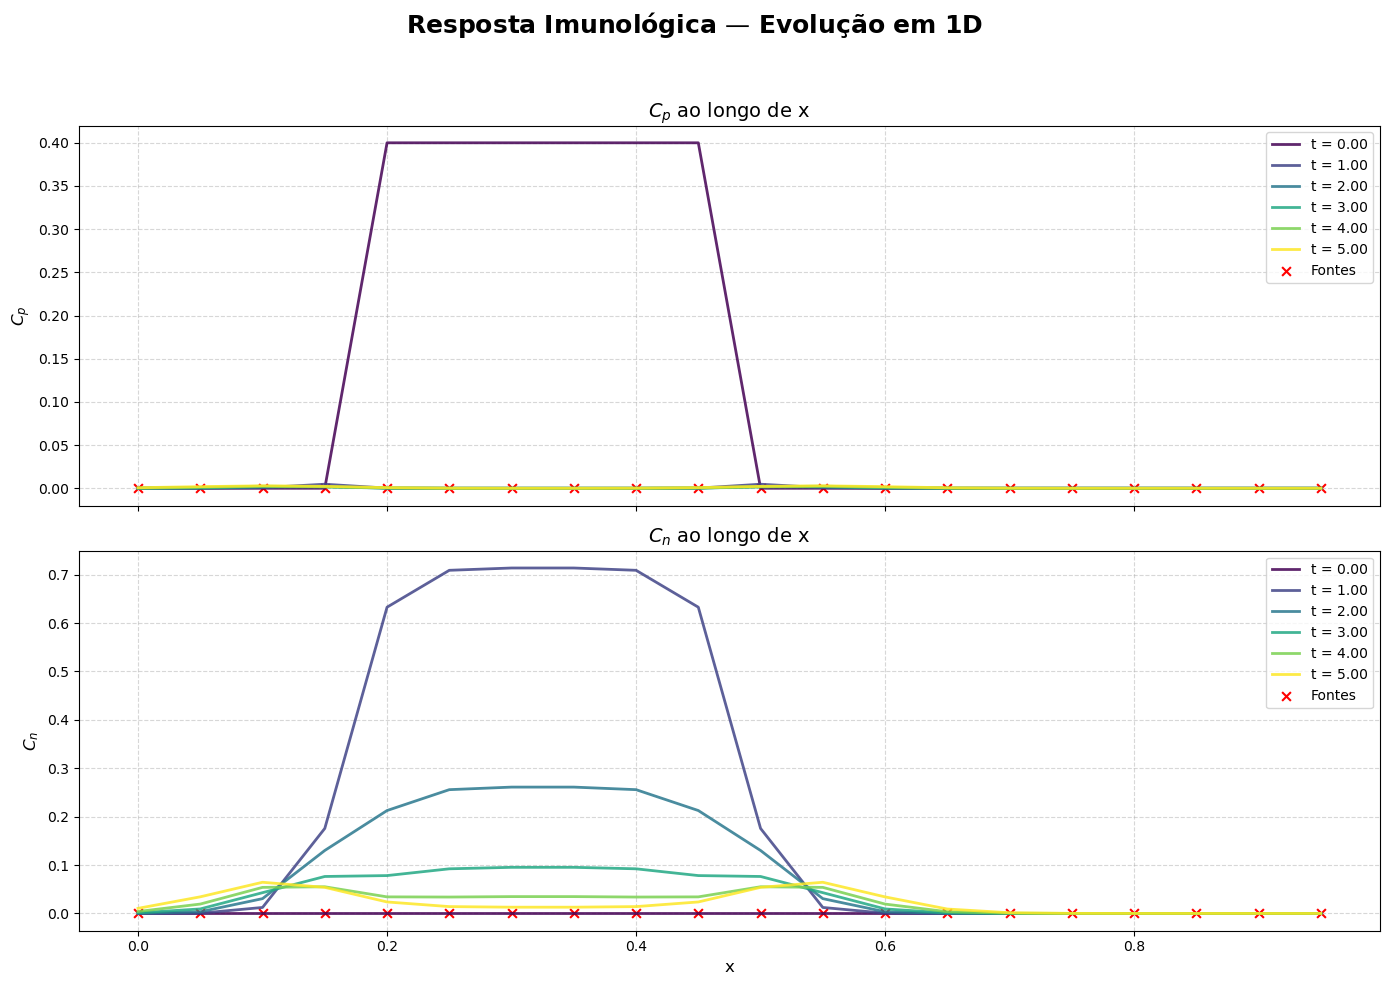

In [113]:
with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

plot_results(size_t,size_x,t_dom,x_dom,Cp_fvm,Cl_fvm,leu_source_points)

## Allocate GPU memmory

In [114]:
def under_sampling(n_samples, Cl, Cp):

    choosen_points = np.linspace(
        0, len(Cl) - 1, num=n_samples, endpoint=True, dtype=int
    )

    reduced_Cl = np.zeros((n_samples, Cl.shape[1], Cl.shape[2]))

    reduced_Cp = np.zeros((n_samples, Cp.shape[1], Cl.shape[2]))

    for i, idx in enumerate(choosen_points):

        reduced_Cl[i, :] = Cl[idx, :, :]

        reduced_Cp[i, :] = Cp[idx, :, :]

    return reduced_Cl, reduced_Cp, choosen_points

In [115]:
size = 4
source = leu_source_points

x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size, endpoint=False, dtype=np.float32
    )

x_idx = np.linspace(0, size, num=size, endpoint=False, dtype=int)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size, endpoint=True, dtype=np.float32)

x_idx_mesh, t_mesh = np.meshgrid(
    x_idx,
    t_np,
)

x_mesh = np.zeros_like(t_mesh)

x_mesh = x_np[x_idx_mesh.ravel()]

x_mesh = np.zeros_like(t_mesh)
source_mesh = np.zeros_like(t_mesh)

x_mesh = x_np[x_idx_mesh.ravel()]
source_mesh = source[x_idx_mesh.ravel()]


In [116]:
def create_input_mesh(source, t_dom, x_dom, size_t, size_x, n_samples=None):

    x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32
    )

    x_idx = np.linspace(0, size_x, num=size_x, endpoint=False, dtype=int)

    if n_samples:

        reduced_Cl, reduced_Cp, choosen_points = under_sampling(
            n_samples, Cl_fvm, Cp_fvm
        )

        t_np = np.linspace(
            t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32
        )[choosen_points]

        x_idx_mesh, t_mesh = np.meshgrid(
            x_idx,
            t_np,
        )

        x_mesh = np.zeros_like(t_mesh)
        source_mesh = np.zeros_like(t_mesh)

        x_mesh = x_np[x_idx_mesh.ravel()]
        source_mesh = source[x_idx_mesh.ravel()]

        return (
            reduced_Cl,
            reduced_Cp,
            t_mesh,
            x_mesh,
            source_mesh,
        )

    t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)

    x_idx_mesh, t_mesh = np.meshgrid(
        x_idx,
        t_np,
    )

    x_mesh = np.zeros_like(t_mesh)
    source_mesh = np.zeros_like(t_mesh)

    x_mesh = x_np[x_idx_mesh.ravel()]
    source_mesh = source[x_idx_mesh.ravel()]

    return (
        t_mesh,
        x_mesh,
        source_mesh,
    )

In [117]:
def allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center_x,
    initial_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    source,
    n_samples=None,
):

    (
        t_mesh,
        x_mesh,
        src_mesh,
    ) = create_input_mesh(source, t_dom, x_dom, size_t, size_x)

    if torch.cuda.is_available():
        device = torch.device("cuda")

    else:
        device = "cpu"

    print("device:", device)

    initial_tc = (
        torch.tensor(initial_cond, dtype=torch.float32)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    center_x_tc = (
        torch.tensor(center_x, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    radius_tc = (
        torch.tensor(radius, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    t_tc = torch.tensor(t_mesh, dtype=torch.float32).reshape(-1, 1)

    x_tc = torch.tensor(x_mesh, dtype=torch.float32).reshape(-1, 1)

    data_tc = torch.cat([t_tc, x_tc], dim=1).requires_grad_(True).to(device)

    src_tc = (
        torch.tensor(src_mesh, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    target = torch.tensor(
        np.array([Cl_fvm.flatten(), Cp_fvm.flatten()]).T,
        dtype=torch.float32,
    )

    if n_samples:

        (
            reduced_Cl,
            reduced_Cp,
            reduced_t_mesh,
            reduced_x_mesh,
            reduced_src_mesh,
        ) = create_input_mesh(source, t_dom, x_dom, size_t, size_x, n_samples)

        reduced_t_tc = torch.tensor(reduced_t_mesh, dtype=torch.float32).reshape(-1, 1)

        reduced_x_tc = torch.tensor(reduced_x_mesh, dtype=torch.float32).reshape(-1, 1)

        reduced_data_tc = (
            torch.cat([reduced_t_tc, reduced_x_tc], dim=1)
            .requires_grad_(True)
            .to(device)
        )

        reduced_src_tc = (
            torch.tensor(reduced_src_mesh, dtype=torch.float32)
            .reshape(-1, 1)
            .requires_grad_(True)
        )

        reduced_target = torch.tensor(
            np.array([reduced_Cl.flatten(), reduced_Cp.flatten()]).T,
            dtype=torch.float32,
        )

        return (
            initial_tc,
            center_x_tc,
            radius_tc,
            data_tc,
            src_tc,
            target,
            reduced_data_tc,
            reduced_src_tc,
            reduced_target,
            device,
        )

    else:
        return (
            initial_tc,
            center_x_tc,
            radius_tc,
            data_tc,
            src_tc,
            target,
            device,
        )

In [118]:
n_samples = 1
(
    initial_tc,
    center_x_tc,
    radius_tc,
    data_tc,
    src_tc,
    target,
    reduced_data_tc,
    reduced_src_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    source,
    n_samples,
)

device: cuda


## Allocation validation

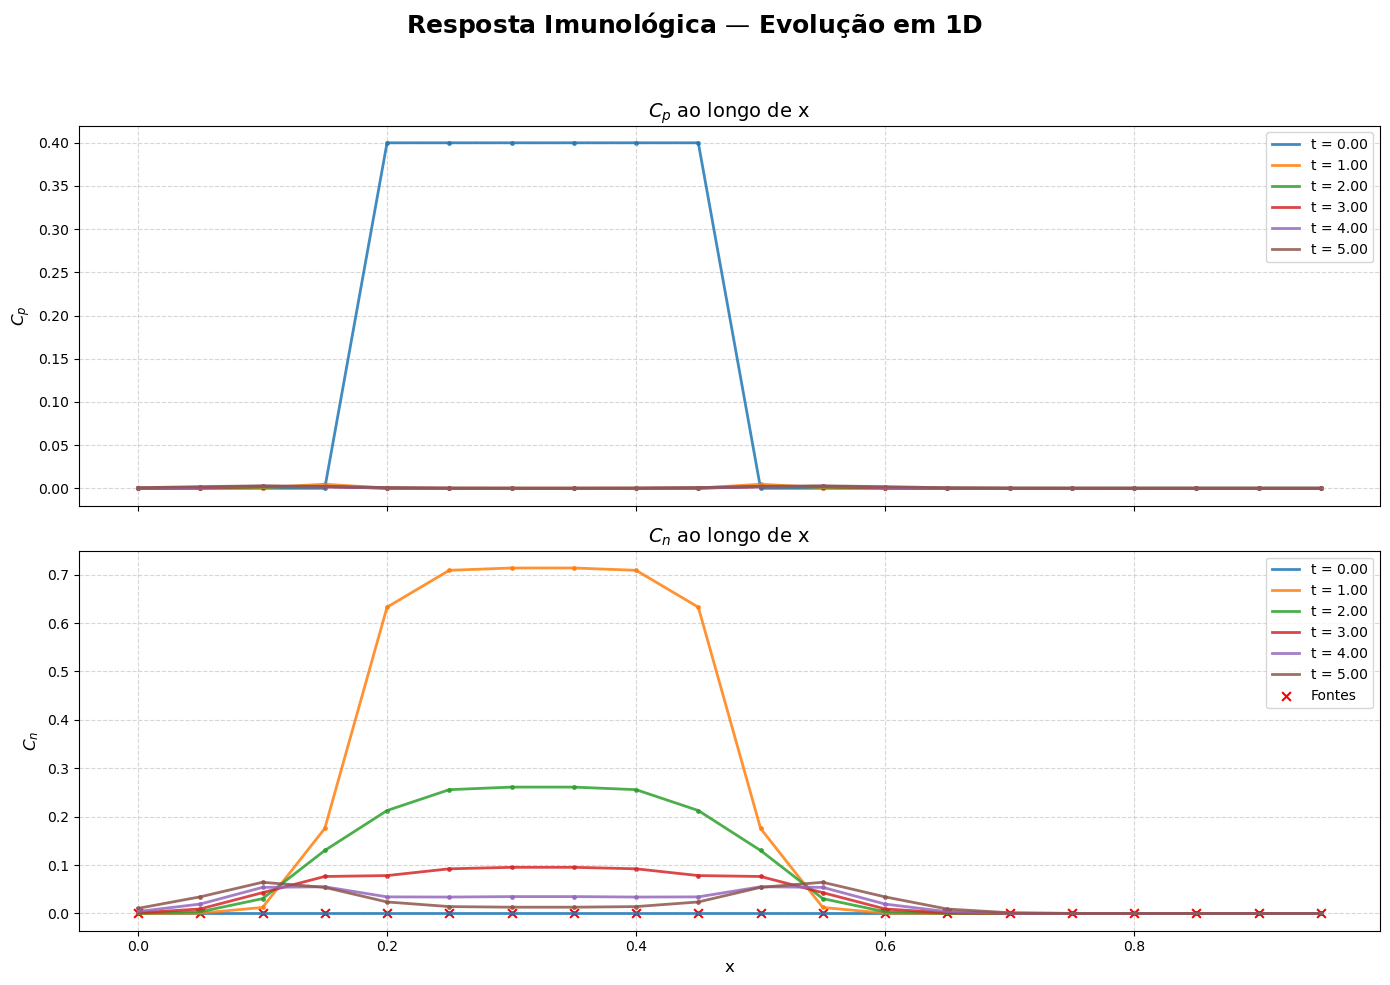

In [119]:
Cl_tc, Cp_tc = target.split(1, dim=1)

Cl = Cl_tc.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp = Cp_tc.cpu().detach().numpy().reshape(Cl_fvm.shape)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32)

# t_np, x_np, Cp, Cl, source_index already defined
# source_index is assumed to be an array of x positions only (1D or Nx1)

time_plot = np.linspace(0, size_t - 1, num=6, endpoint=True, dtype=int)

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

fig.suptitle(
    "$\\bf{Resposta\\ Imunológica}$ — Evolução em 1D", fontsize=18, weight="bold"
)

source_index = np.argwhere(leu_source_points[:, 0] == 1).ravel()


for i, time_inst in enumerate(time_plot):
    axes[0].plot(
        x_np,
        Cp[time_inst].squeeze(),
        label=f"t = {t_np[time_inst]:.2f}",
        linewidth=2,
        alpha=0.85,
    )

    time_ft = np.argwhere(
        data_tc[:, 0].cpu().detach().numpy() == t_np[time_inst]
    ).ravel()

    axes[0].scatter(
        data_tc[time_ft, 1].cpu().detach().numpy(),
        Cp_tc[time_ft].detach().numpy(),
        s=6,
        alpha=0.85,
    )

axes[0].set_title("$C_p$ ao longo de x", fontsize=14)
axes[0].set_ylabel("$C_p$", fontsize=12)
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot Cl
for i, time_inst in enumerate(time_plot):
    axes[1].plot(
        x_np,
        Cl[time_inst].squeeze(),
        label=f"t = {t_np[time_inst]:.2f}",
        linewidth=2,
        alpha=0.85,
    )

    time_ft = np.argwhere(
        data_tc[:, 0].cpu().detach().numpy() == t_np[time_inst]
    ).ravel()

    axes[1].scatter(
        data_tc[time_ft, 1].cpu().detach().numpy(),
        Cl_tc[time_ft].detach().numpy(),
        s=6,
        alpha=0.85,
    )

axes[1].scatter(
    x_np[source_index],
    np.zeros((len(source_index))),
    color="red",
    label="Fontes",
    s=40,
    marker="x",
)

axes[1].set_title("$C_n$ ao longo de x", fontsize=14)
axes[1].set_xlabel("x", fontsize=12)
axes[1].set_ylabel("$C_n$", fontsize=12)
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Archtecture handling

In [120]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

# PINN

## Training

In [121]:
def generate_pde_points(num_points, device):
    # Generate random (uniform) points in [0, 1) for time, x, and y
    t = torch.rand(num_points, 1, dtype=torch.float32) * 5

    x = torch.rand(num_points, 1, dtype=torch.float32)

    C = torch.zeros((len(x), 2), dtype=torch.float32)

    # Set requires_grad=True so we can compute PDE derivatives using autograd
    # Move each tensor to the specified device
    return (
        torch.cat([t.requires_grad_(True), x.requires_grad_(True)], dim=1).to(device),
        C.to(device),
    )


def generate_boundary_points(num_points, device):

    t = torch.rand(num_points, 1, dtype=torch.float32) * 5

    x = (
        torch.tensor([0.0, 1], dtype=torch.float32)
        .repeat(num_points // 2, 1)
        .view(-1, 1)
    )

    C = torch.zeros((len(x), 2), dtype=torch.float32)

    return (
        torch.cat([t.requires_grad_(True), x.requires_grad_(True)], dim=1).to(device),
        C.to(device),
    )


def generate_initial_points(num_points, device, center_x_tc, radius_tc, initial_tc):
    t = torch.zeros(num_points, 1, dtype=torch.float32)

    x = torch.rand(num_points, 1, dtype=torch.float32)

    euclidean_distances = ((x - center_x_tc) ** 2) ** 0.5

    inside_circle_mask = euclidean_distances <= radius_tc

    C_init = torch.zeros((len(x), 2), dtype=torch.float32)

    C_init[:, 1] = inside_circle_mask.ravel() * initial_tc.ravel()

    return (
        torch.cat([t.requires_grad_(True), x.requires_grad_(True)], dim=1).to(device),
        C_init.to(device),
    )


def boundary_condition(pred, batch, Dn, X_nb, Db):

    n = (
        torch.tensor([-1, 1], dtype=torch.float32)
        .repeat(len(pred) // 2, 1)
        .requires_grad_(True)
        .view(-1, 1)
        .to(device)
    )

    dCl = torch.autograd.grad(
        pred[:, 0],
        batch,
        torch.ones_like(pred[:, 0]),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp = torch.autograd.grad(
        pred[:, 1],
        batch,
        torch.ones_like(pred[:, 1]),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Separar as derivadas parciais em duas colunas
    _, dCl_dx = dCl.tensor_split(2, dim=1)
    _, dCp_dx = dCp.tensor_split(2, dim=1)

    Cl_boundary = Dn * dCl_dx * n - X_nb * torch.matmul(pred[:, 0].ravel(), dCp_dx * n)

    Cp_boundary = Db * dCp_dx * n

    # 4) Return them as one tensor, do NOT re-flag requires_grad
    return torch.cat([Cl_boundary, Cp_boundary], dim=1)


def generate_pde_source(original_source, h, batch):
   
    _, x_batch = batch.tensor_split(2, dim=1)  # [B, 1]
    x_domain = torch.arange(0, 1, h).view(-1, 1).to(device)  # [N, 1]

    # Identify active source locations in x_domain
    source_locs = x_domain[original_source.view(-1) == 1]  # shape [M, 1], where M ≤ N
    source_locs

    # Compute bounds
    l_bound = source_locs - h  # [M, 1]
    u_bound = source_locs + h  # [M, 1]

    # Broadcast and check
    x_batch_exp = x_batch[:, None, :]     # [B, 1, 1]
    l_bound_exp = l_bound[None, :, :]     # [1, M, 1]
    u_bound_exp = u_bound[None, :, :]     # [1, M, 1]

    # Check if x_batch[i] is within any [l_bound[j], u_bound[j]]
    in_range = (x_batch_exp > l_bound_exp) & (x_batch_exp < u_bound_exp)  # [B, M, 1]
    match = in_range.any(dim=1)  # [B, 1]

    # Generate new source
    new_source = torch.zeros_like(x_batch)
    new_source[match] = 1.0

    return new_source


def pde(
    pred,
    batch,
    h,
    cb,
    phi,
    lambd_nb,
    Db,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
    Dn,
    X_nb,
    original_source,
):

    dCl = torch.autograd.grad(
        pred[:, 0],
        batch,
        torch.ones_like(pred[:, 0]),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp = torch.autograd.grad(
        pred[:, 1],
        batch,
        torch.ones_like(pred[:, 1]),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Separar as derivadas parciais em duas colunas
    dCl_dt, dCl_dx = dCl.tensor_split(2, dim=1)
    dCp_dt, dCp_dx = dCp.tensor_split(2, dim=1)

    d2Cl = torch.autograd.grad(
        dCl_dx,
        batch,
        torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    d2Cp = torch.autograd.grad(
        dCp_dx,
        batch,
        torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Separar as derivadas parciais em duas colunas
    _, d2Cl_dx2 = d2Cl.tensor_split(2, dim=1)
    _, d2Cp_dx2 = d2Cp.tensor_split(2, dim=1)

    # Calculating Cl value

    source = generate_pde_source(original_source,h,batch)

    qn = y_n * pred[:, 1:2] * (Cn_max - pred[:, 0:1]) * source # [1000, 1]
    rn = lambd_bn * pred[:, 0:1] * pred[:, 1:2] + mi_n * pred[:, 0:1]  # [1000, 1]

    Cl_eq = (
        Dn * d2Cl_dx2 - X_nb * (pred[:, 1:2] * d2Cp_dx2 + dCl_dx * dCp_dx) - rn + qn
    ) - dCl_dt * phi  # All shapes [1000, 1]

    qb = cb * pred[:, 1:2]
    rb = lambd_nb * pred[:, 0:1] * pred[:, 1:2]

    Cp_eq = Db * d2Cp_dx2 - rb + qb - dCp_dt * phi  # All shapes [1000, 1]

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [128]:
class Trainer:

    def shuffle_data(self, *arrays):
        indices = np.random.permutation(arrays[0].shape[0])

        return tuple(array[indices] for array in arrays)

    def train_test_split(
        self,
        *arrays,
        test_size=0.5,
        shuffle=True,
    ):
        with torch.no_grad():
            if shuffle:
                arrays = self.shuffle_data(*arrays)

            # Determine train-test split index
            total_samples = arrays[0].shape[0]
            if 0 < test_size < 1:
                split_idx = total_samples - int(total_samples * test_size)
            elif isinstance(test_size, int) and 1 <= test_size < total_samples:
                split_idx = total_samples - test_size
            else:
                raise ValueError(
                    "Invalid test_size: must be a float (0 < x < 1) or int < len(data)"
                )

            # Perform the split for each array
            train_set = tuple(array[:split_idx].to(self.device) for array in arrays)
            test_set = tuple(array[split_idx:].to(self.device) for array in arrays)

            # Flatten and return
            return (*train_set, *test_set)

    def add_loss(self, loss_obj, weigth=1):
        self.losses.append(loss_obj)
        self.lossesW.append(weigth)

    def __init__(
        self,
        n_epochs,
        batch_size,
        model,
        device,
        target=[],
        data=[],
        patience=300,
        tolerance=1e-3,
        val_steps=None,
        print_steps=5000,
        validation=None,
        optimizer=None,
        scheduler=None,
    ):

        self.model = model.to(device)
        self.device = device
        self.constant_properties = constant_properties
        self.validation = validation
        self.tolerance = tolerance
        self.patience = patience
        self.optimizer = optimizer
        self.scheduler = scheduler if scheduler else None
        self.print_steps = print_steps
        self.losses = []
        self.lossesW = []

        if len(data) != 0 and len(target) != 0:

            self.n_batchs = int(ceil(len(data) / batch_size))

            self.val_steps = val_steps if val_steps else self.n_batchs

            self.n_it = int(n_epochs * self.n_batchs)

            if self.validation:
                (
                    self.data_train,
                    self.target_train,
                    self.data_test,
                    self.target_test,
                ) = self.train_test_split(
                    data,
                    target,
                    test_size=self.validation,
                )

            else:

                self.data_train = data
                self.data_test = None
                self.target_train = target
                self.target_test = None

            self.add_loss(
                RMSE(
                    self.data_train,
                    self.target_train,
                    device,
                    name="Data Loss",
                    batch_size=batch_size,
                    shuffle=False,
                )
            )

            return

        self.n_it = n_epochs
        self.val_steps = val_steps if val_steps else 1

        return

    def train(
        self,
    ):

        if self.losses == []:
            print("No loss function added")
            return

        loss_dict = {}

        for loss in self.losses:
            loss_dict[loss.name] = []

        loss_dict["val"] = []

        patience_count = 0
        val_loss = torch.tensor([1000])

        for it in range(self.n_it):
            start_time = time.time()  # Start timing the iteration

            self.model.zero_grad()
            self.optimizer.zero_grad()
            total_loss = 0
            losses = []
            
            for weighth, loss_obj in zip(self.lossesW, self.losses):

                loss = loss_obj.forward(self.model)

                total_loss += loss * weighth

                losses.append((loss * weighth).item())

                if it % self.n_batchs == 0: 
                    loss_dict[loss_obj.name].append(loss.item())

            # Backward pass
            total_loss.backward()

            # Update weights
            self.optimizer.step()

            iteration_time = time.time() - start_time  # Calculate iteration duration

            if it / self.n_batchs % self.print_steps == 0:
                print(
                    "Iteration {}: total loss {:.4f}, losses: {}, learning rate: {:.10f}, time: {:.4f}s".format(
                        it // self.n_batchs,
                        total_loss.item(),
                        losses,
                        self.scheduler.get_last_lr()[0],
                        iteration_time,
                    )
                )

            self.scheduler.step(total_loss)

            # Computing validation loss

            if it % self.val_steps:
                with torch.no_grad():
                    val_old = val_loss

                    val_loss = torch.mean(
                        torch.sum(
                            ((self.target_test - self.model(self.data_test))) ** 2,
                            dim=1,
                        )
                        ** 0.5
                    )

                if it % self.n_batchs == 0: 
                    loss_dict["val"].append(val_loss.item())

                if self.tolerance and self.validation:

                    if (
                        abs(val_old.item() - val_loss.item()) / val_old.item()
                        < self.tolerance
                    ):
                        patience_count += 1

                    else:
                        patience_count = 0

                    if patience_count >= self.patience:

                        print(
                            "Iteration {}: total loss {:.4f}, losses: {}, learning rate: {:.10f}, time: {:.4f}s".format(
                                it // self.n_batchs,
                                total_loss.item(),
                                losses,
                                self.scheduler.get_last_lr()[0],
                                iteration_time,
                            )
                        )

                        print("Early break!")

                        break

        return self.model, loss_dict

In [129]:
hidden_layer = [32, 32, 32, 32, 32]
dtype = torch.float32
model = FullyConnectedNetwork(2, 2, hidden_layer, dtype=dtype)
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

FullyConnectedNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Tanh()
    (10): Linear(in_features=32, out_features=2, bias=True)
  )
)
4386


In [130]:
n_epochs = int(1e4)
batch_size = 1e3
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.8, 0.999))
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.9999,
    patience=1000,
    threshold=1e-3,
    threshold_mode="rel",
    cooldown=0,
    min_lr=1e-5,
    eps=1e-08,
)

trainer = Trainer(
    n_epochs=n_epochs,
    batch_size=batch_size,
    model=model,
    device=device,
    target=target,
    data=data_tc,
    patience=5000,
    tolerance=0.01,
    validation=0.2,
    optimizer=optimizer,
    scheduler=lr_scheduler,
    print_steps=2000,
)

In [131]:
init_loss = LOSS_INITIAL(
    batch_size=batch_size,
    device=device,
    loss="RMSE",
    name="LossInital",
)

init_loss.setBatchGenerator(generate_initial_points, center_x_tc, radius_tc, initial_tc)

trainer.add_loss(init_loss)


bnd_loss = LOSS_PINN(
    batch_size=batch_size,
    device=device,
    loss="RMSE",
    name="LossBoundary",
)

bnd_loss.setBatchGenerator(generate_boundary_points)

bnd_loss.setPinnFunction(boundary_condition, Dn, X_nb, Db)

trainer.add_loss(bnd_loss)


pde_loss = LOSS_PINN(
    batch_size=batch_size,
    device=device,
    loss="RMSE",
    name="LossPDE",
)

pde_loss.setBatchGenerator(generate_pde_points)

original_source = torch.tensor(leu_source_points).to(device)

pde_loss.setPinnFunction(
    pde,
    h,
    cb,
    phi,
    lambd_nb,
    Db,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
    Dn,
    X_nb,
    original_source,
)

trainer.add_loss(pde_loss, 5)

In [132]:
model, loss_dict = trainer.train()


Iteration 0: total loss 7.8461, losses: [0.33189088106155396, 0.3038473129272461, 0.0010320229921489954, 7.209367752075195], learning rate: 0.0010000000, time: 0.0121s
Iteration 2000: total loss 0.1355, losses: [0.03624868765473366, 0.049667809158563614, 0.0004882901557721198, 0.049086831510066986], learning rate: 0.0009991004, time: 0.0069s
Iteration 4000: total loss 0.0509, losses: [0.011046862229704857, 0.017927108332514763, 3.4525670344009995e-05, 0.021936092525720596], learning rate: 0.0009985010, time: 0.0061s
Iteration 6000: total loss 0.0299, losses: [0.00429623993113637, 0.007887111976742744, 3.3869197068270296e-05, 0.017634199932217598], learning rate: 0.0009976028, time: 0.0070s
Iteration 8000: total loss 0.0232, losses: [0.0038808691315352917, 0.007774422876536846, 7.963149073475506e-06, 0.011579526588320732], learning rate: 0.0009956094, time: 0.0068s


## Validation

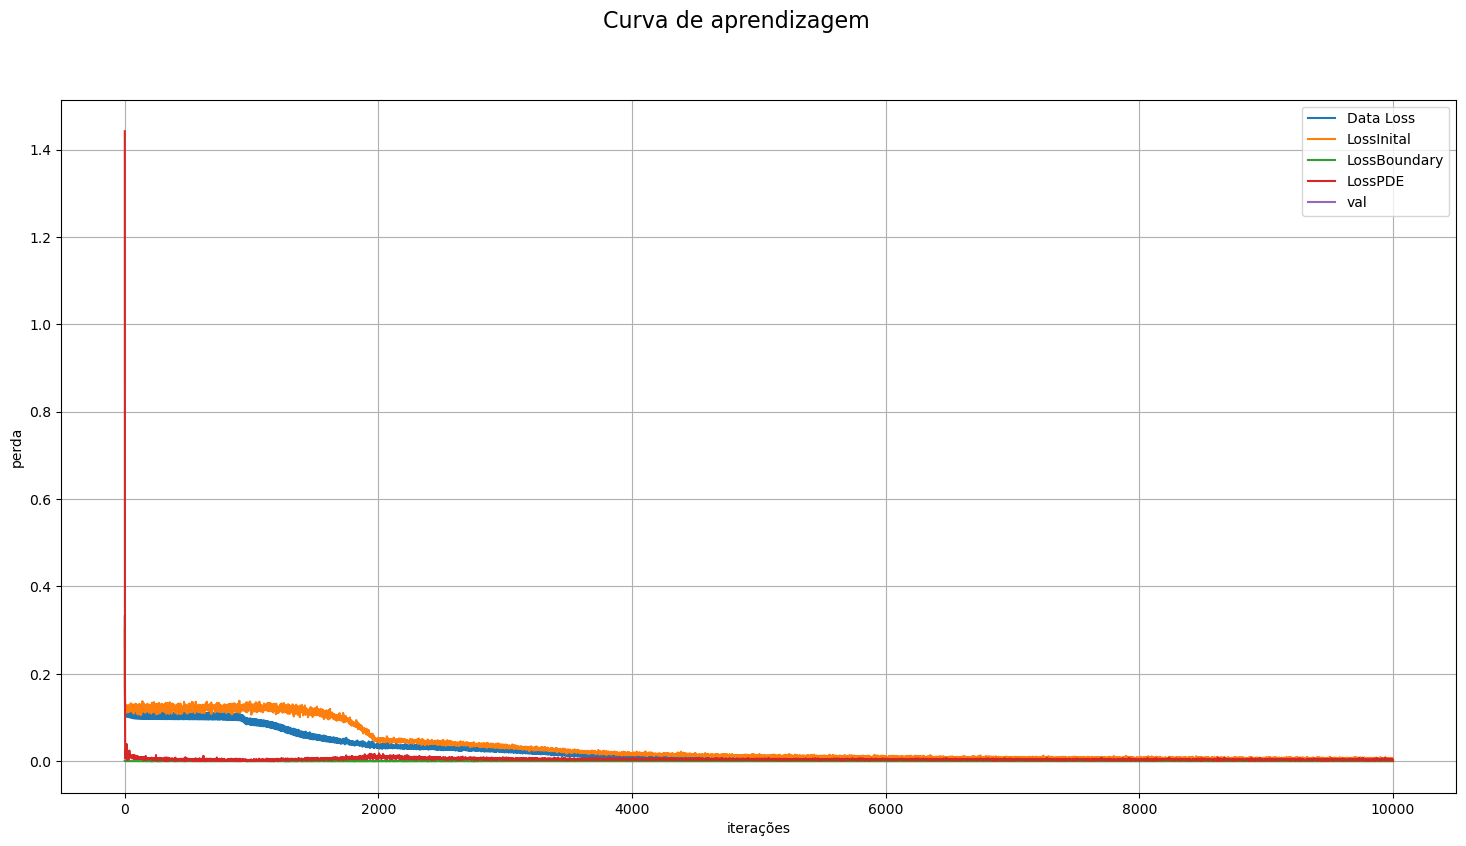

In [133]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

for loss in loss_dict:
    ax.plot(
        range(len(loss_dict[loss])),
        loss_dict[loss],
        label=loss,
    )

# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [134]:
model = trainer.model

mesh = data_tc.to(device)

with torch.no_grad():
    pred_pinn_dev = model(mesh)

pred_pinn = pred_pinn_dev.cpu().detach().numpy()

In [135]:
Cl_pinn_device, Cp_pinn_device = pred_pinn_dev.split(1, dim=1)

Cl_pinn_np = Cl_pinn_device.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp_pinn_np = Cp_pinn_device.cpu().detach().numpy().reshape(Cl_fvm.shape)

## Plot functions

In [136]:
import matplotlib.animation as animation


def plot_comparison(
    size_t, size_x, t_dom, x_dom, Cb, Cn, Cb_pinn, Cn_pinn, leu_source_points
):

    t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
    x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32
    )

    # t_np, x_np, Cb, Cn, source_index already defined
    # source_index is assumed to be an array of x positions only (1D or Nx1)

    time_plot = np.linspace(0, size_t - 1, num=6, endpoint=True, dtype=int)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

    fig.suptitle(
        "$\\bf{Resposta\\ Imunológica}$ — Evolução em 1D", fontsize=18, weight="bold"
    )

    colors = plt.cm.viridis(np.linspace(0, 1, len(time_plot)))

    source_index = np.argwhere(leu_source_points[:, 0] == 1).ravel()

    # Plot Cb
    for i, time_inst in enumerate(time_plot):
        axes[0, 0].plot(
            x_np,
            Cb[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[0, 0].scatter(
        x_np[source_index],  # assuming source_index is Nx2 still
        np.zeros(source_index.shape),  # put the markers at the top for visibility
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[0, 0].set_title("$C_p$ ao longo de x, FVM", fontsize=14)
    axes[0, 0].set_ylabel("$C_p$", fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle="--", alpha=0.5)

    # Plot Cn
    for i, time_inst in enumerate(time_plot):
        axes[0, 1].plot(
            x_np,
            Cn[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[0, 1].scatter(
        x_np[source_index],
        np.zeros((len(source_index))),
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[0, 1].set_title("$C_n$ ao longo de x, FVM", fontsize=14)
    axes[0, 1].set_xlabel("x", fontsize=12)
    axes[0, 1].set_ylabel("$C_n$", fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle="--", alpha=0.5)

    # Plot Cb
    for i, time_inst in enumerate(time_plot):
        axes[1, 0].plot(
            x_np,
            Cb_pinn[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[1, 0].scatter(
        x_np[source_index],  # assuming source_index is Nx2 still
        np.zeros(source_index.shape),  # put the markers at the top for visibility
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[1, 0].set_title("$C_p$ ao longo de x, FVM", fontsize=14)
    axes[1, 0].set_ylabel("$C_p$", fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle="--", alpha=0.5)

    # Plot Cn
    for i, time_inst in enumerate(time_plot):
        axes[1, 1].plot(
            x_np,
            Cn_pinn[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[1, 1].scatter(
        x_np[source_index],
        np.zeros((len(source_index))),
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[1, 1].set_title("$C_n$ ao longo de x, FVM", fontsize=14)
    axes[1, 1].set_xlabel("x", fontsize=12)
    axes[1, 1].set_ylabel("$C_n$", fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def animate_1D_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cb,
    Cn,
    Cb_pinn,
    Cn_pinn,
    leu_source_points,
    delta_t,
    frame_time,
    name="evolucao_1D",
    show=False,
):
    """
    Gera uma animação que mostra a evolução de Cp e Cn em 1D ao longo do tempo.
    Parametros:
        size_t, size_x: nº de pontos no tempo e espaço
        t_dom, x_dom: domínios (lista ou tupla [min, max] para tempo e espaço)
        Cb, Cn: arrays de shape (size_t, size_x) com valores de Cp e Cn
        leu_source_points: array booleano (ou 0/1) indicando onde há fontes (mesmo shape de x ou Nx1).
    """

    t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
    x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32
    )

    # Converte leu_source_points para índices (caso seja um array Nx1 de 0/1)
    # Se já estiver pronto, pode ajustar conforme sua lógica
    source_index = np.argwhere(leu_source_points[:, 0] == 1).ravel()

    # Cria figura e eixos
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
    fig.suptitle(
        "$\\bf{Resposta\\ Imunológica}$ — Evolução em 1D", fontsize=18, weight="bold"
    )

    # Primeiro subplot: Cp
    ax_cp = axes[0, 0]
    (line_cp,) = ax_cp.plot([], [], "b-", lw=2, alpha=0.85, label="Cp")
    ax_cp.set_ylabel("$C_p$")
    ax_cp.set_title("$C_p$ ao longo de x, FVM", fontsize=14)
    ax_cp.grid(True, linestyle="--", alpha=0.5)
    ax_cp.set_xlim(0, 1)
    ax_cp.set_ylim(0, np.max(Cb) * 1.1)
    ax_cp.legend()

    # Segundo subplot: Cn
    ax_cn = axes[0, 1]
    (line_cn,) = ax_cn.plot([], [], "g-", lw=2, alpha=0.85, label="Cn")
    sc_cn = ax_cn.scatter(
        x_np[source_index],
        np.zeros_like(source_index),
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )
    ax_cn.set_xlabel("x", fontsize=12)
    ax_cn.set_ylabel("$C_n$")
    ax_cn.set_title("$C_n$ ao longo de x, FVM", fontsize=14)
    ax_cn.grid(True, linestyle="--", alpha=0.5)
    ax_cn.set_xlim(0, 1)
    ax_cn.set_ylim(0, np.max(Cn) * 1.1)
    ax_cn.legend()

    # Primeiro subplot: Cp_pinn
    ax_cp_pinn = axes[1, 0]
    (line_cp_pinn,) = ax_cp_pinn.plot([], [], "b-", lw=2, alpha=0.85, label="Cp_pinn")
    ax_cp_pinn.set_ylabel("$C_p$")
    ax_cp_pinn.set_title("$C_p$ ao longo de x, PINN", fontsize=14)
    ax_cp_pinn.grid(True, linestyle="--", alpha=0.5)
    ax_cp_pinn.set_xlim(0, 1)
    ax_cp_pinn.set_ylim(0, np.max(Cb) * 1.1)
    ax_cp_pinn.legend()

    # Segundo subplot: Cn_pinn
    ax_cn_pinn = axes[1, 1]
    (line_cn_pinn,) = ax_cn_pinn.plot([], [], "g-", lw=2, alpha=0.85, label="Cn_pinn")
    sc_cn_pinn = ax_cn_pinn.scatter(
        x_np[source_index],
        np.zeros_like(source_index),
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )
    ax_cn_pinn.set_xlabel("x", fontsize=12)
    ax_cn_pinn.set_ylabel("$C_n$")
    ax_cn_pinn.set_title("$C_n$ ao longo de x, PINN", fontsize=14)
    ax_cn_pinn.grid(True, linestyle="--", alpha=0.5)
    ax_cn_pinn.set_xlim(0, 1)
    ax_cn_pinn.set_ylim(0, np.max(Cn) * 1.1)
    ax_cn_pinn.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Função para inicializar a animação
    def init():
        line_cp.set_data([], [])
        line_cn.set_data([], [])
        line_cp_pinn.set_data([], [])
        line_cn_pinn.set_data([], [])
        return line_cp, line_cn, line_cp_pinn, line_cn_pinn, sc_cn, sc_cn_pinn

    # Função de atualização a cada frame
    def update(frame):
        # frame varia de 0 até size_t-1
        cp_vals = Cb[frame].squeeze()  # shape (size_x,)
        cn_vals = Cn[frame].squeeze()
        cp_vals_pinn = Cb_pinn[frame].squeeze()  # shape (size_x,)
        cn_vals_pinn = Cn_pinn[frame].squeeze()

        # Atualiza as linhas
        line_cp.set_data(x_np, cp_vals)
        line_cn.set_data(x_np, cn_vals)
        line_cp_pinn.set_data(x_np, cp_vals_pinn)
        line_cn_pinn.set_data(x_np, cn_vals_pinn)

        # Atualiza posições dos scatters se necessário (aqui, continua em 0)
        sc_cn.set_offsets(
            np.column_stack((x_np[source_index], np.zeros_like(source_index)))
        )

        sc_cn_pinn.set_offsets(
            np.column_stack((x_np[source_index], np.zeros_like(source_index)))
        )

        # Ajusta título (opcional) para mostrar tempo
        ax_cp.set_title(f"$C_p$ ao longo de x, t = {t_np[frame]:.2f}")
        ax_cn.set_title(f"$C_n$ ao longo de x, t = {t_np[frame]:.2f}")

        return line_cp, line_cn, line_cp_pinn, line_cn_pinn, sc_cn

    frames_indices = range(0, size_t, delta_t)

    # Cria animação
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=frames_indices,  # total de frames = nº de instantes de tempo
        init_func=init,
        blit=True,  # se quiser performance, use True, mas requer cuidado
        interval=frame_time,  # interval em ms entre frames
    )

    # Salvar como vídeo MP4 (necessita FFmpeg instalado):

    if show:
        plt.show()

    ani.save("fvm_animations/" + name + ".mp4", fps=5)

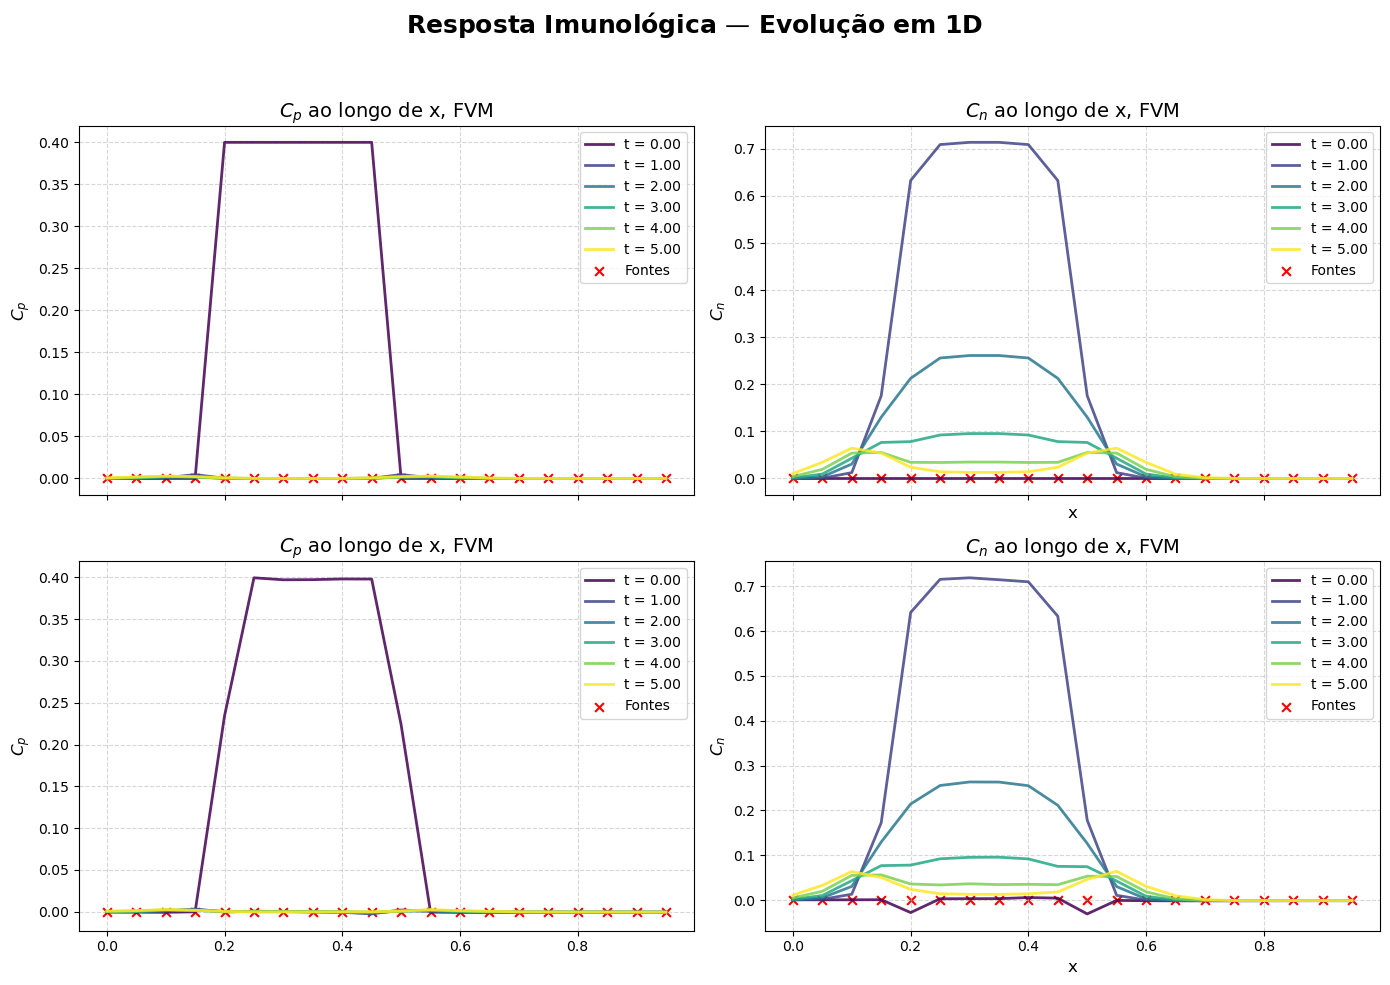

In [137]:
plot_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_fvm,
    Cl_fvm,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
)


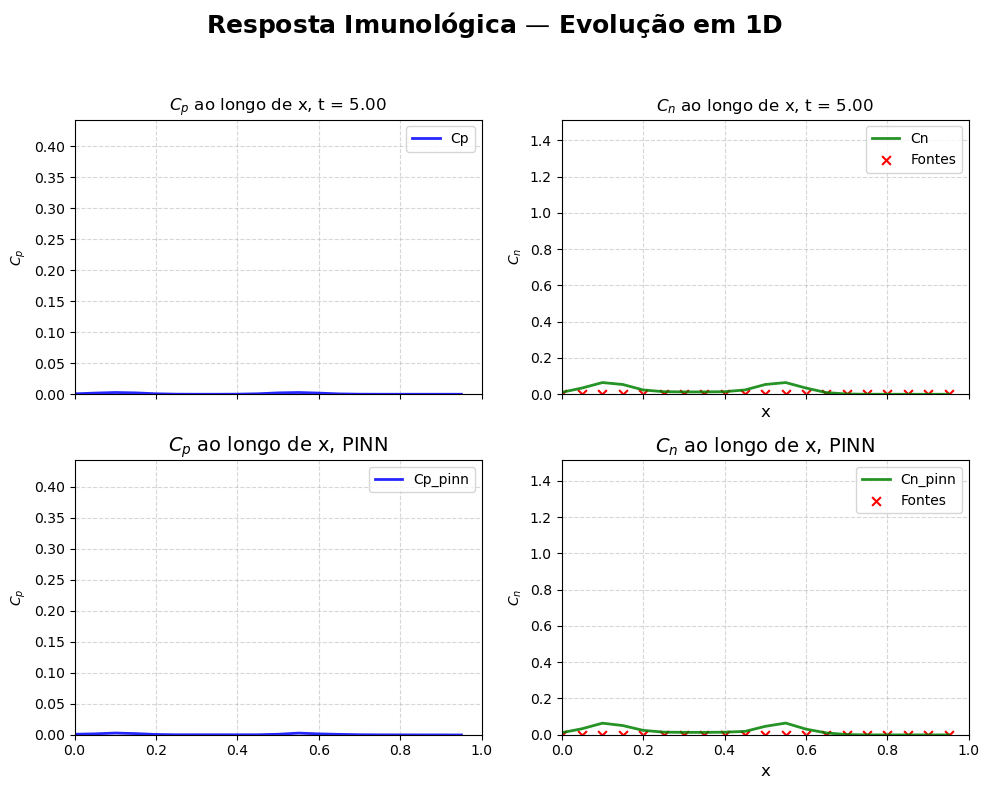

In [138]:

animate_1D_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_fvm,
    Cl_fvm,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
    (size_t - 1) // 100,
    150,
    name="evolucao_1D__",
)


## Saving model weights and biases

In [139]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
layers.0.weight 	 torch.Size([32, 2])
layers.0.bias 	 torch.Size([32])
layers.2.weight 	 torch.Size([32, 32])
layers.2.bias 	 torch.Size([32])
layers.4.weight 	 torch.Size([32, 32])
layers.4.bias 	 torch.Size([32])
layers.6.weight 	 torch.Size([32, 32])
layers.6.bias 	 torch.Size([32])
layers.8.weight 	 torch.Size([32, 32])
layers.8.bias 	 torch.Size([32])
layers.10.weight 	 torch.Size([2, 32])
layers.10.bias 	 torch.Size([2])


In [140]:
import os

arch_str
pinn_file = "epochs_{}__batch_{}__arch_".format(n_epochs, batch_size) + arch_str

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

del model
del trainer

NameError: name 'arch_str' is not defined

# Training setup

In [96]:
import torch
import pickle as pk
import argparse
import os
import json
from pinn import *

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]


# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])


size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)


(
    initial_tc,
    center_x_tc,
    center_y_tc,
    radius_tc,
    t_tc,
    x_tc,
    y_tc,
    target,
    reduced_t_tc,
    reduced_x_tc,
    reduced_y_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center[0],
    center[1],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    3000,
)


arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

model = generate_model(arch_str).to(device).apply(init_weights)

print(model)

decay_rate = 0.9985
n_epochs = 300
val = 0.2
batch_size = int(len(t_tc) * (1 - val) / 10)
lr_rate = 6e-4

trainer = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    initial_tc=initial_tc,
    center_x_tc=center_x_tc,
    center_y_tc=center_y_tc,
    radius_tc=radius_tc,
    t_tc=reduced_t_tc,
    x_tc=reduced_x_tc,
    y_tc=reduced_y_tc,
    target=reduced_target,
    device=device,
    n_points=batch_size,
    constant_properties=constant_properties,
    validation=val,
    tolerance=0.02,
    patience=20,
    normalize=True,
    lr_rate=lr_rate,
)


(
    model,
    C_pde_loss_it,
    C_boundary_loss_it,
    C_initial_loss_it,
    C_data_loss_it,
    val_loss_it,
) = trainer.execute()


# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

pinn_file = (
    "decay_rates_{:.4}__lr_rates_{:.4}__arch_".format(decay_rate, lr_rate) + arch_str
)

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

with open("learning_curves/C_pde_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_pde_loss_it.cpu().numpy(), openfile)

with open("learning_curves/C_boundary_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_boundary_loss_it.cpu().numpy(), openfile)


with open("learning_curves/C_initial_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_initial_loss_it.cpu().numpy(), openfile)


with open("learning_curves/C_data_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_data_loss_it.cpu().numpy(), openfile)


with open("learning_curves/val_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(val_loss_it.cpu().numpy(), openfile)

del model
del trainer

Steps in time = 501
Steps in space_x = 20
Steps in space_y = 1

device: cuda
Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 801 but got size 800 for tensor number 2 in the list.

# Evaluation setup

In [1]:
from glob import glob
import time
import pickle as pk
import os
import json
from pinn import *

In [2]:
def load_model(file_name, device):
    cwd = os.getcwd()

    arch_str = (
        ("__")
        .join(file_name.split("/")[-1].split(".pt")[0].split("__")[2:])
        .split("arch_")[-1]
    )

    model = generate_model(arch_str).to(device)

    model.load_state_dict(
        torch.load(cwd + "/" + file_name, weights_only=True, map_location=device)
    )

    print(model.eval())

    return model


def read_speed_ups(speed_up_list):
    speed_up_obj = {}
    for i, file in enumerate(speed_up_list):
        with open(file, "rb") as f:
            speed_up_obj[i] = pk.load(f)

    return speed_up_obj

In [3]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]


# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])


size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)


(
    initial_tc,
    center_x_tc,
    center_y_tc,
    radius_tc,
    t_tc,
    x_tc,
    y_tc,
    target,
    reduced_t_tc,
    reduced_x_tc,
    reduced_y_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center[0],
    center[1],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    3000,
)

Steps in time = 10001
Steps in space_x = 20
Steps in space_y = 20

device: cuda


In [40]:
nn_list = glob("nn_parameters/*")
run_list = list(
    map(
        lambda file: file.split("pinn_sim/")[-1]
        .split(".pkl")[0]
        .split("prediction_")[-1],
        glob("pinn_sim/*"),
    )
)

total = len(nn_list)

target = target.cpu().detach()

t_scaler = Scaler()
x_scaler = Scaler()
y_scaler = Scaler()
target_scaler = Scaler()

t_scaler.fit(t_tc)
x_scaler.fit(x_tc)
y_scaler.fit(y_tc)
target_scaler.fit(target)

norm_t_tc = t_scaler.normalize(t_tc)
norm_x_tc = x_scaler.normalize(x_tc)
norm_y_tc = y_scaler.normalize(y_tc)
norm_target = target_scaler.normalize(target)

for nn_num, nn_file in enumerate(nn_list[0:3]):

    if nn_file.split(".")[-1] == "pt":

        pinn_file = nn_file.split("nn_parameters/")[-1].split(".pt")[0]

        print(f"\n{nn_num+1} of {total}")

        print("=" * 20)

        print("PINN:", pinn_file)

        if pinn_file in run_list:
            print("Already evaluated")

        else:
            model = load_model(nn_file, device)

            speed_up_obj = read_speed_ups(speed_up_list)

            output = {
                "mean_speed_up": [],
                "std_speed_up": 0,
                "mean_speed_comp_up": [],
                "std_speed_comp_up": 0,
                "mean_speed_up_pinn": [],
                "std_speed_up_pinn": 0,
                "mean_serial_time": [],
                "std_serial_time": 0,
                "mean_cuda_time": [],
                "std_cuda_time": 0,
                "mean_pinn_time": [],
                "std_pinn_time": 0,
            }

            prediction = {}

            error = np.zeros((len(speed_up_obj.keys()), len(target)))

            for i in speed_up_obj.keys():

                start = time.time()

                mesh = torch.cat([norm_t_tc, norm_x_tc, norm_y_tc], dim=1).to(device)

                with torch.no_grad():
                    pred_pinn_dev = model(mesh)

                pred_pinn = pred_pinn_dev.cpu().detach().numpy()

                end = time.time()

                pinn_time = end - start

                speed_up_obj[i]["pinn_time"] = pinn_time

                speed_up_obj[i]["speed_up_pinn"] = (
                    speed_up_obj[i]["serial_time"] / pinn_time
                )

                output["mean_speed_up"].append(speed_up_obj[i]["speed_up"])

                output["mean_speed_comp_up"].append(speed_up_obj[i]["speed_comp_up"])

                output["mean_speed_up_pinn"].append(speed_up_obj[i]["speed_up_pinn"])

                output["mean_serial_time"].append(speed_up_obj[i]["serial_time"])

                output["mean_cuda_time"].append(speed_up_obj[i]["cuda_time"])

                output["mean_pinn_time"].append(speed_up_obj[i]["pinn_time"])

                aux = ((pred_pinn - norm_target.cpu().detach().numpy()) ** 2) ** 0.5

                error[i] = aux[:, 0] + aux[:, 1]

            output["std_speed_up"] = np.std(output["mean_speed_up"])
            output["std_speed_comp_up"] = np.std(output["mean_speed_comp_up"])
            output["std_speed_up_pinn"] = np.std(output["mean_speed_up_pinn"])
            output["std_serial_time"] = np.std(output["mean_serial_time"])
            output["std_cuda_time"] = np.std(output["mean_cuda_time"])
            output["std_pinn_time"] = np.std(output["mean_pinn_time"])

            output["mean_speed_up"] = np.mean(output["mean_speed_up"])
            output["mean_speed_comp_up"] = np.mean(output["mean_speed_comp_up"])
            output["mean_speed_up_pinn"] = np.mean(output["mean_speed_up_pinn"])
            output["mean_serial_time"] = np.mean(output["mean_serial_time"])
            output["mean_cuda_time"] = np.mean(output["mean_cuda_time"])
            output["mean_pinn_time"] = np.mean(output["mean_pinn_time"])

            rmse = np.mean(error.flatten())

            max_ae = np.max(error.flatten())

            prediction["pred_pinn"] = pred_pinn
            prediction["target"] = norm_target.cpu().detach().numpy()

            print("Erro absoluto médio", rmse)
            print("Erro absoluto máximo", max_ae)
            print(
                "Speed Up: {} +/-{}".format(
                    output["mean_speed_up"], output["std_speed_up"]
                )
            )
            print(
                "Compilation Speed Up: {} +/-{}".format(
                    output["mean_speed_comp_up"], output["std_speed_comp_up"]
                )
            )
            print(
                "PINN Speed Up: {} +/-{}".format(
                    output["mean_speed_up_pinn"], output["std_speed_up_pinn"]
                )
            )

            with open("pinn_sim/output_" + pinn_file + ".pkl", "wb") as openfile:
                # Reading from json file
                pk.dump(output, openfile)

            with open("pinn_sim/prediction_" + pinn_file + ".pkl", "wb") as openfile:
                # Reading from json file
                pk.dump(prediction, openfile)


1 of 23289
PINN: decay_rates_0.95__lr_rates_0.0001__arch_Tanh--16__Elu--8__Sigmoid--16__
Already evaluated

2 of 23289
PINN: decay_rates_0.9745__lr_rates_0.001__arch_Elu--32__Elu--8__Elu--16__
Already evaluated

3 of 23289
PINN: decay_rates_0.95__lr_rates_0.001__arch_Sigmoid--16__ReLU--32__SiLU--16__
Already evaluated


# Printing simulations

In [31]:
import matplotlib.pyplot as plt

with open("pinn_sim/prediction_" + pinn_file + ".pkl", "rb") as openfile:
    # Reading from json file
    prediction = pk.load(openfile)

In [32]:
pred_pinn = prediction["pred_pinn"]
target = prediction["target"]

In [34]:
Cl_pinn_device, Cp_pinn_device = np.split(pred_pinn, 2, axis=1)

Cl_pinn_np = Cl_pinn_device.reshape(Cp_fvm.shape)

Cp_pinn_np = Cp_pinn_device.reshape(Cp_fvm.shape)

Cl_target_dev, Cp_target_dev = np.split(target, 2, axis=1)

Cl_target_np = Cl_target_dev.reshape(Cp_fvm.shape)

Cp_target_np = Cp_target_dev.reshape(Cp_fvm.shape)

In [35]:
Cl_target_np.shape

(10001, 20, 20)

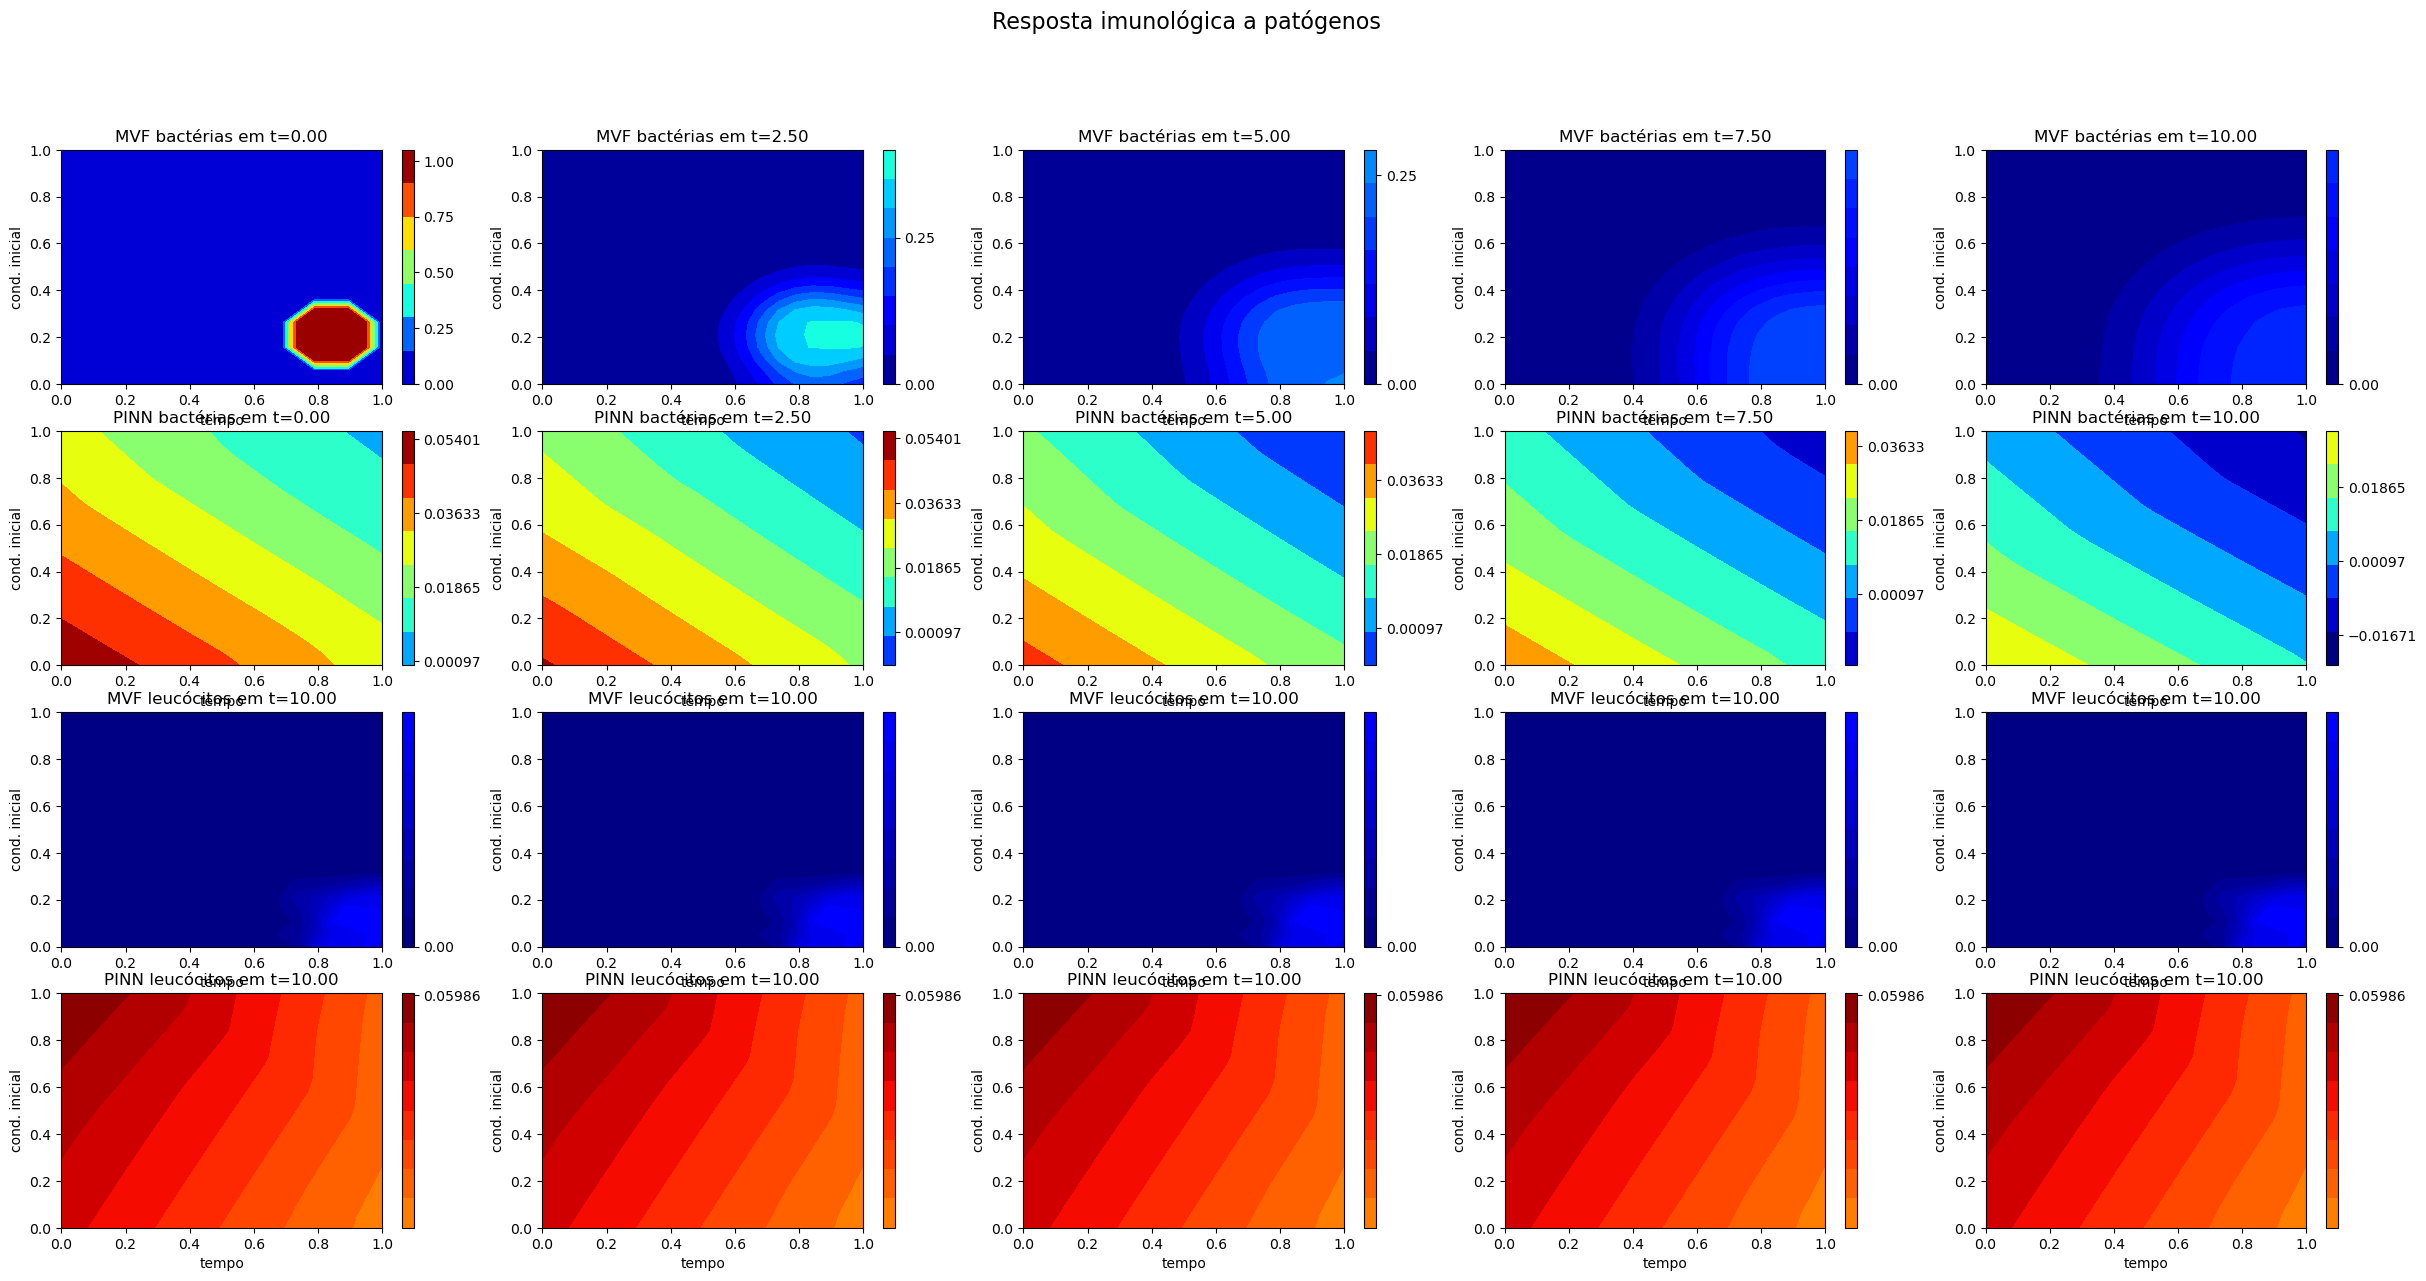

In [ ]:
t = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)

X, Y = np.meshgrid(x, y)

time_plot = np.linspace(0, len(t) - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + 1)

    vmin = np.min(Cp_target_np)
    vmax = np.max(Cp_target_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_target_np[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("MVF bactérias em t={:.2f}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cp_pinn_np)
    vmax = np.max(Cp_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("PINN bactérias em t={:.2f}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 2 + 1)

    vmin = np.min(Cl_target_np)
    vmax = np.max(Cl_target_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_target_np[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("MVF leucócitos em t={:.2f}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))


for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 3 + 1)

    vmin = np.min(Cl_pinn_np)
    vmax = np.max(Cl_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("PINN leucócitos em t={:.2f}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

In [21]:
from glob import glob

list_nn_parameters = glob("nn_parameters/*")

list_learning_curves = glob("learning_curves/*")

list_pinn_sim = glob("pinn_sim/*")